## First, let's calculate the momentum of pentaquark from e+p center of mass frame. 

In [1]:
nEvents = 100000
maxTrialNumbers = 1000000000

In [2]:
import math
from pylorentz import Momentum4
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import time



# Define constants
mass_pentaquark = 4.312  # GeV
mass_jpsi = 3.097        # GeV
mass_proton = 0.938      # GeV
mass_electron = 0.000511        # GeV

protonBeam_enegry = 275
electronBeam_energy = 18

# Not used anymore
# pentquarkEnergy1 = 100  # GeV in lab frame Lower limit 
# pentquarkEnergy2 = 200  # GeV in lab frame Upper limit
pentaquarkEtaLow = 20  # low angle cut for generation
pentaquarkEtaHigh = 1.9 # high angle for generation
pentaquarkTheta1 = 2*np.arctan( np.exp(-pentaquarkEtaLow))
pentaquarkTheta2 = 2*np.arctan( np.exp(-pentaquarkEtaHigh))
print (f"theta range: {pentaquarkTheta1} ~ {pentaquarkTheta2}")
print (f"Eta range: {pentaquarkEtaHigh} ~ {pentaquarkEtaLow}")


theta range: 4.122307244877116e-09 ~ 0.29693606528712396
Eta range: 1.9 ~ 20


In [3]:
mom4_protonBeam_lab = Momentum4(
    protonBeam_enegry,   0,    0,   math.sqrt( protonBeam_enegry **2 - mass_proton**2) 
)
mom4_electronBeam_lab = Momentum4(
    electronBeam_energy,   0,    0,   -math.sqrt( electronBeam_energy **2 - mass_electron**2) 
)

mom4_total_lab = mom4_protonBeam_lab + mom4_electronBeam_lab
beta_x_total_lab = mom4_total_lab.p_x / mom4_total_lab.e
beta_y_total_lab = mom4_total_lab.p_y / mom4_total_lab.e
beta_z_total_lab = mom4_total_lab.p_z / mom4_total_lab.e
beta_magnitude_total_lab = math.sqrt(beta_x_total_lab**2 + beta_y_total_lab**2 + beta_z_total_lab**2)

# print (f"COM energy = {mom4_total_lab.m} GeV")
# print (beta_x_total_lab)
# print (beta_y_total_lab)
# print (beta_z_total_lab)


# Boost the beams to the COM frame
mom4_protonBeam_COM = mom4_protonBeam_lab.boost(    beta_x_total_lab, beta_y_total_lab, beta_z_total_lab, beta = beta_magnitude_total_lab)
mom4_electronBeam_COM = mom4_electronBeam_lab.boost(beta_x_total_lab, beta_y_total_lab, beta_z_total_lab, beta = beta_magnitude_total_lab)


In [4]:
print( mom4_protonBeam_lab) 
print( mom4_electronBeam_lab) 
print (mom4_protonBeam_COM)
print (mom4_electronBeam_COM)

mom_pc_COM =  math.sqrt(((mom4_total_lab.m**2 + mass_electron**2 - mass_pentaquark**2)/(2*mom4_total_lab.m))**2 - mass_electron**2)
energy_pc_COM = math.sqrt(mom_pc_COM**2 + mass_pentaquark**2)
energy_electron_COM = math.sqrt(mom_pc_COM**2 + mass_electron**2)

print (f"mom_pc_COM = {mom_pc_COM} GeV")
print (f"energy_pc_COM = {energy_pc_COM} GeV")
print (f"energy_electron_COM = {energy_electron_COM} GeV")
print (f"total energy = {energy_electron_COM+ energy_pc_COM } GeV")
print (f"diff = {energy_electron_COM+ energy_pc_COM - mom4_total_lab.m}")


Momentum4(275, 0, 0, 274.998)
Momentum4(18, 0, 0, -18)
Momentum4(70.3608, 0, 0, 70.3546)
Momentum4(70.3546, 0, 0, -70.3546)
mom_pc_COM = 70.29163005168488 GeV
energy_pc_COM = 70.42376445009829 GeV
energy_electron_COM = 70.29163005354229 GeV
total energy = 140.7153945036406 GeV
diff = 0.0


In [5]:
# theta_pc_COM = np.arccos(2 * np.random.rand() - 1)  # Random polar angle
# phi_pc_COM = 2 * np.pi * np.random.rand() # random azimuthal angle

# mom4_pc_COM = Momentum4(
#     energy_pc_COM, 
#     mom_pc_COM * np.sin(theta_pc_COM) * np.cos(phi_pc_COM),
#     mom_pc_COM * np.sin(theta_pc_COM) * np.sin(phi_pc_COM),
#     mom_pc_COM * np.cos(theta_pc_COM)
# )
# print (f"COM frame: {mom4_pc_COM}")

# mom4_pc_lab = mom4_pc_COM.boost( -beta_x_total_lab, -beta_y_total_lab, -beta_z_total_lab, beta = beta_magnitude_total_lab)
# print (f"lab frame: {mom4_pc_lab}")
# print (f"theta = {mom4_pc_lab.theta}")
# print (f"eta = {mom4_pc_lab.eta}")



In [25]:
today_date = datetime.today().strftime('%Y%m%d')
outputFile = f"Pentaquark_hepmc_output_{today_date}_p{mom4_protonBeam_lab.e}GeV_e{mom4_electronBeam_lab.e}GeV_two_body_kinematics_eta{pentaquarkEtaHigh}-{pentaquarkEtaLow}_{nEvents}evts.hepmc"


# Storage for jpsi transverse momentum (p_T) values
jpsi_pt_values = []
jpsi_eta_values = []
jpsi_phi_values = []
ele_pt_values = []
ele_eta_values = []
pos_pt_values = []
proton_pt_values = []
proton_eta_values = []
reco_mass_values = [] 
reco_jpsimass_values = [] 

pc_eta_lab_values = [] 
pc_phi_lab_values = []
pc_pt_lab_values = [] 

pc_eta_COM_values = [] 
pc_phi_COM_values = []
pc_pt_COM_values = [] 


proton_p_lab_values = []
proton_eta_lab_values = []
    
    # NOW. Let's print HEPMC3 script.
with open(outputFile, "w") as f:
    f.write(
        """\
HepMC::Version 3.02.06
HepMC::Asciiv3-START_EVENT_LISTING"
W Weight
""")
        
eventNum = 0
trialNum = 0
# Generate 100 pentaquark decays
# for _ in range(maxTrialNumbers):
for _ in tqdm(range(maxTrialNumbers), desc="Processing Jobs", unit="job") :
    trialNum = trialNum+1
    
    if eventNum > nEvents:
        break
    
    # Kinamtics of the penta-quark:
    # theta_pc_COM = np.arccos(2 * np.random.rand() - 1)  # Random polar angle
    # theta_pc_COM = np.arccos( 1 - np.random.rand()* .001 )  # Random polar angle // Constrain cos(theta > 0)
    theta_pc_COM = np.arccos( np.random.rand() )  # Random polar angle // Constrain cos(theta) : 0 - 1
    phi_pc_COM = 2 * np.pi * np.random.rand() # random azimuthal angle
    mom4_pc_COM = Momentum4(
        energy_pc_COM, 
        mom_pc_COM * np.sin(theta_pc_COM) * np.cos(phi_pc_COM),
        mom_pc_COM * np.sin(theta_pc_COM) * np.sin(phi_pc_COM),
        mom_pc_COM * np.cos(theta_pc_COM)
    )
    mom4_pc_lab = mom4_pc_COM.boost( -beta_x_total_lab, -beta_y_total_lab, -beta_z_total_lab, beta = beta_magnitude_total_lab)
    
    if mom4_pc_lab.eta > pentaquarkEtaLow or mom4_pc_lab.eta < pentaquarkEtaHigh:
        continue  # Skip this iteration

    
    # print (f"COM frame: {mom4_pc_COM}")
    # print (f"lab frame: {mom4_pc_lab}")


    # Define random decay angles for the J/psi in the pentaquark rest frame
    theta_decay = np.arccos(2 * np.random.rand() - 1)  # Random polar angle
    phi_decay = 2 * np.pi * np.random.rand()           # Random azimuthal angle

    # Calculate the decay momentum in the rest frame
    p_decay = np.sqrt((mass_pentaquark**2 - (mass_jpsi + mass_proton)**2) *
                      (mass_pentaquark**2 - (mass_jpsi - mass_proton)**2)) / (2 * mass_pentaquark)

    # Create 4-vectors for J/psi and proton in the pentaquark's rest frame
    jpsi_pc_frame = Momentum4(
        np.sqrt(mass_jpsi**2 + p_decay**2),
        p_decay * np.sin(theta_decay) * np.cos(phi_decay),
        p_decay * np.sin(theta_decay) * np.sin(phi_decay),
        p_decay * np.cos(theta_decay)
    )
    beta_x_jpsi_pc_frame = jpsi_pc_frame.p_x / jpsi_pc_frame.e
    beta_y_jpsi_pc_frame = jpsi_pc_frame.p_y / jpsi_pc_frame.e
    beta_z_jpsi_pc_frame = jpsi_pc_frame.p_z / jpsi_pc_frame.e
    beta_magnitude_jpsi_pc_frame = np.sqrt(beta_x_jpsi_pc_frame**2 + beta_y_jpsi_pc_frame**2 + beta_z_jpsi_pc_frame**2)

    # print ("e, px, py, pz = ", jpsi_pc_frame.e, jpsi_pc_frame.p_x, jpsi_pc_frame.p_y, jpsi_pc_frame.p_z)
    # print (np.sqrt(jpsi_pc_frame.e**2 - jpsi_pc_frame.p_x**2 - jpsi_pc_frame.p_y**2 - jpsi_pc_frame.p_z**2))
    
    proton_pc_frame = Momentum4(
        np.sqrt(mass_proton**2 + p_decay**2),
        -jpsi_pc_frame.p_x,
        -jpsi_pc_frame.p_y,
        -jpsi_pc_frame.p_z
    )

    # Define random decay angles for e+e- in J/psi rest frame
    theta_e_decay = np.arccos(2 * np.random.rand() - 1)  # Random polar angle
    phi_e_decay = 2 * np.pi * np.random.rand()           # Random azimuthal angle
    # Calculate the decay momentum in the rest frame
    ele_decay = np.sqrt( (mass_jpsi/2)**2 - mass_electron**2 )

    ele_jpsi_frame = Momentum4(
        np.sqrt(mass_electron**2 + ele_decay**2),
        ele_decay * np.sin(theta_e_decay) * np.cos(phi_e_decay),
        ele_decay * np.sin(theta_e_decay) * np.sin(phi_e_decay),
        ele_decay * np.cos(theta_e_decay)
    )
    pos_jpsi_frame = Momentum4(
        np.sqrt(mass_electron**2 + ele_decay**2),
       - ele_decay * np.sin(theta_e_decay) * np.cos(phi_e_decay),
       - ele_decay * np.sin(theta_e_decay) * np.sin(phi_e_decay),
       - ele_decay * np.cos(theta_e_decay)
    )

    ele_pc_frame = ele_jpsi_frame.boost(-beta_x_jpsi_pc_frame, -beta_y_jpsi_pc_frame, -beta_z_jpsi_pc_frame, beta=beta_magnitude_jpsi_pc_frame)
    pos_pc_frame = pos_jpsi_frame.boost(-beta_x_jpsi_pc_frame, -beta_y_jpsi_pc_frame, -beta_z_jpsi_pc_frame, beta=beta_magnitude_jpsi_pc_frame)

    # print ( ele_pc_frame.p_x + pos_pc_frame.p_x - jpsi_pc_frame.p_x)
    
    # Define random angles for the pentaquark's movement in the lab frame
    # theta_lab =   np.random.uniform(pentaquarkTheta1, pentaquarkTheta2) 
    # phi_lab = np.random.uniform(0,2*np.pi)    
        #target_pentaquark_momentum =  np.random.uniform(pentquarkEnergy1,pentquarkEnergy2)
        
    # Calculate lab frame momentum components for the pentaquark
    # px_lab = target_pentaquark_momentum * np.sin(theta_lab) * np.cos(phi_lab)
    # py_lab = target_pentaquark_momentum * np.sin(theta_lab) * np.sin(phi_lab)
    # pz_lab = target_pentaquark_momentum * np.cos(theta_lab)
    # pentaquark_energy_lab = np.sqrt(mass_pentaquark**2 + target_pentaquark_momentum**2)

    # Create the pentaquark 4-momentum in the lab frame

    # Calculate the beta vector and magnitude for the lab frame
    beta_x = mom4_pc_lab.p_x/mom4_pc_lab.e
    beta_y = mom4_pc_lab.p_y/mom4_pc_lab.e
    beta_z = mom4_pc_lab.p_z/mom4_pc_lab.e
    beta_magnitude = np.sqrt(beta_x**2 + beta_y**2 + beta_z**2)
    
    # Boost the J/psi to the lab frame
    jpsi_lab = jpsi_pc_frame.boost(-beta_x, -beta_y, -beta_z, beta=beta_magnitude)
    proton_lab = proton_pc_frame.boost(-beta_x, -beta_y, -beta_z, beta=beta_magnitude)
    ele_lab = ele_pc_frame.boost(-beta_x, -beta_y, -beta_z, beta=beta_magnitude)
    pos_lab = pos_pc_frame.boost(-beta_x, -beta_y, -beta_z, beta=beta_magnitude)
    
    # kinematic cuts:
    if ( proton_lab.eta > 0 and proton_lab.eta < 100
        and ele_lab.eta > 0 and ele_lab.eta < 100 
        and pos_lab.eta > 0 and pos_lab.eta < 100 ) == False :
        continue

    pc_eta_COM_values.append(mom4_pc_COM.eta)
    pc_phi_COM_values.append(mom4_pc_COM.phi)
    pc_pt_COM_values.append(mom4_pc_COM.p_t)
    
    pc_eta_lab_values.append(mom4_pc_lab.eta)
    pc_phi_lab_values.append(mom4_pc_lab.phi)
    pc_pt_lab_values.append(mom4_pc_lab.p_t)

    # Calculate transverse momentum (p_T) of the J/psi in the lab frame
    jpsi_pt = np.sqrt(jpsi_lab.p_x**2 + jpsi_lab.p_y**2)
    jpsi_pt_values.append(jpsi_pt)
    jpsi_eta_values.append(jpsi_lab.eta)
    jpsi_phi_values.append(jpsi_lab.phi)

    ele_pt_values.append(ele_lab.p_t)
    ele_eta_values.append(ele_lab.eta)
    pos_pt_values.append(pos_lab.p_t)
    proton_pt_values.append(proton_lab.p_t)
    proton_eta_values.append(proton_lab.eta)

    proton_p_lab_values.append(proton_lab.p)
    proton_eta_lab_values.append(proton_lab.eta)
    # print ( ele_lab.p_x + pos_lab.p_x - jpsi_lab.p_x)

    final_sum = ele_lab + pos_lab + proton_lab
    # print ("final mass = ", final_sum.m)
    # print ("final p = ", final_sum.p)
    reco_mass_values.append(final_sum.m)
    reco_jpsimass_values.append ( (ele_lab + pos_lab).m) 

    with open(outputFile, "a") as f:
        f.write(f"E {eventNum} 1 5\n")
    eventNum = eventNum+1

    with open(outputFile, "a") as f:
        f.write(
            """\
U GEV MM
W 1.0000000000000000000000e+00
A 0 GenCrossSection 0.00000000e+00 0.00000000e+00 -1 -1
A 0 GenPdfInfo 0 0 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0 0
A 0 alphaQCD 0
A 0 alphaQED 0
A 0 event_scale 0
A 0 signal_process_id 151
""")
    # proton beam energy at centre-of-mass frame
    with open(outputFile, "a") as f:
        f.write(f"P 1 0 2212 {mom4_protonBeam_lab.p_x} {mom4_protonBeam_lab.p_y} {mom4_protonBeam_lab.p_z} {mom4_protonBeam_lab.e} {mom4_protonBeam_lab.m} 4\n")
        f.write(f"P 2 0 11 {mom4_electronBeam_lab.p_x} {mom4_electronBeam_lab.p_y} {mom4_electronBeam_lab.p_z} {mom4_electronBeam_lab.e} {mom4_electronBeam_lab.m} 4\n")
        f.write("V -1 0 [1,2]\n")
        f.write(f"P 3 -1 2212 {proton_lab.p_x} {proton_lab.p_y} {proton_lab.p_z} {proton_lab.e} {proton_lab.m} 1\n")
        f.write(f"P 4 -1 11 {ele_lab.p_x} {ele_lab.p_y} {ele_lab.p_z} {ele_lab.e} {ele_lab.m} 1\n")
        f.write(f"P 5 -1 -11 {pos_lab.p_x} {pos_lab.p_y} {pos_lab.p_z} {pos_lab.e} {pos_lab.m} 1\n")
with open(outputFile, "a") as f:
    f.write("HepMC::Asciiv3-END_EVENT_LISTING\n")


print( f"{eventNum}/{trialNum} generated")

Processing Jobs:   0%|          | 0/1000000000 [00:00<?, ?job/s]

100001/196471 generated


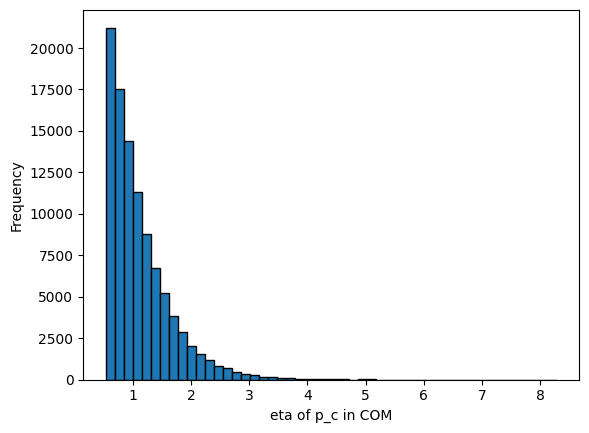

In [26]:
# Plot the distribution of J/psi p_T
plt.hist(pc_eta_COM_values, bins=50, edgecolor='k')
plt.xlabel(r"eta of p_c in COM")
plt.ylabel("Frequency")
plt.show()

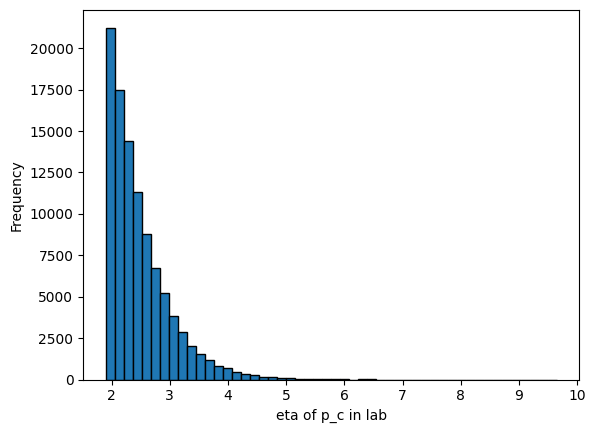

In [27]:
# Plot the distribution of J/psi p_T
plt.hist(pc_eta_lab_values, bins=50, edgecolor='k')
plt.xlabel(r"eta of p_c in lab")
plt.ylabel("Frequency")
plt.show()



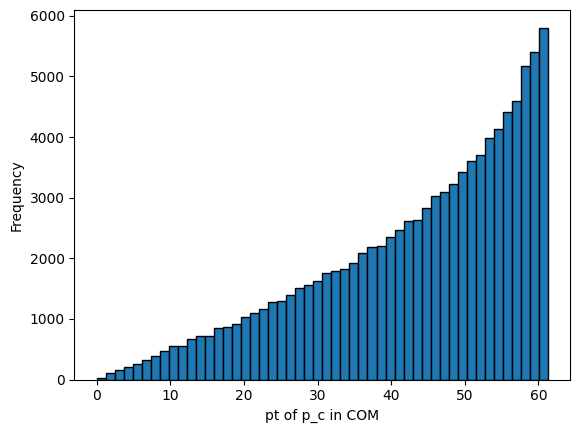

In [28]:

plt.hist(pc_pt_COM_values, bins=50, edgecolor='k')
plt.xlabel(r"pt of p_c in COM")
plt.ylabel("Frequency")
plt.show()

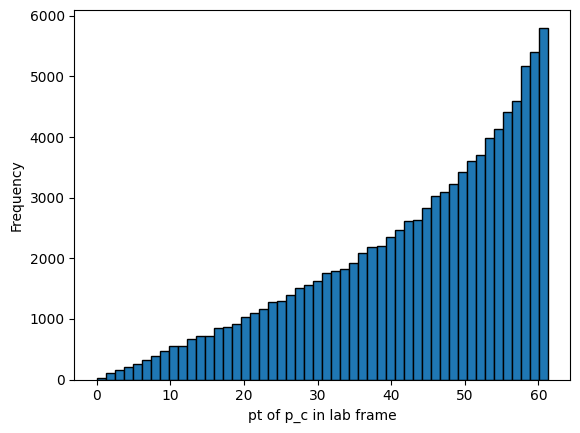

In [29]:

plt.hist(pc_pt_lab_values, bins=50, edgecolor='k')
plt.xlabel(r"pt of p_c in lab frame")
plt.ylabel("Frequency")
plt.show()

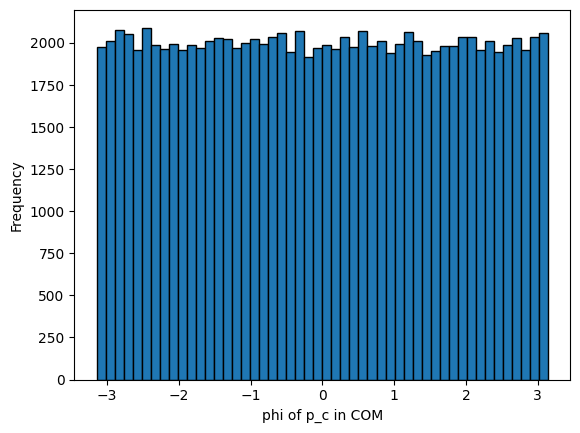

In [30]:
plt.hist(pc_phi_COM_values, bins=50, edgecolor='k')
plt.xlabel(r"phi of p_c in COM")
plt.ylabel("Frequency")
plt.show()

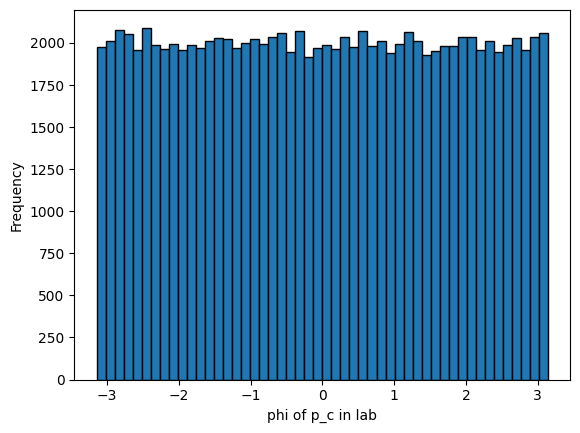

In [31]:
plt.hist(pc_phi_lab_values, bins=50, edgecolor='k')
plt.xlabel(r"phi of p_c in lab")
plt.ylabel("Frequency")
plt.show()

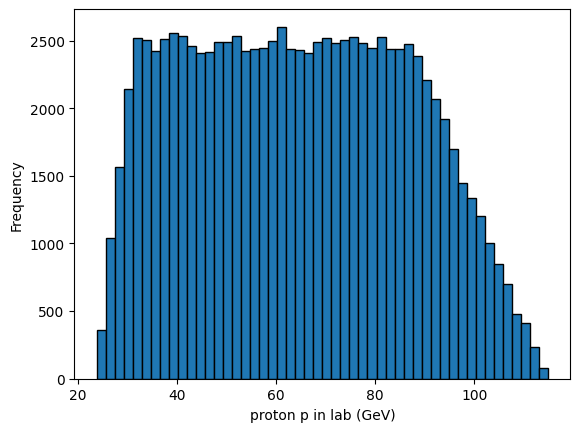

In [32]:
plt.hist(proton_p_lab_values, bins=50, edgecolor='k')
plt.xlabel(r"proton p in lab (GeV)")
plt.ylabel("Frequency")
plt.show()



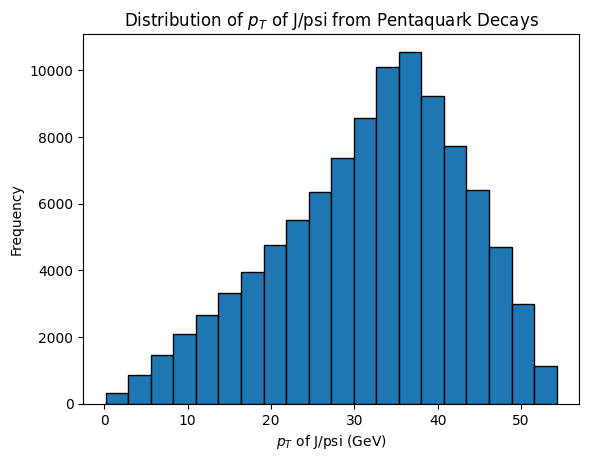

In [33]:
# Plot the distribution of J/psi p_T
plt.hist(jpsi_pt_values, bins=20, edgecolor='k')
plt.xlabel(r"$p_T$ of J/psi (GeV)")
plt.ylabel("Frequency")
plt.title(r"Distribution of $p_T$ of J/psi from Pentaquark Decays")
plt.show()


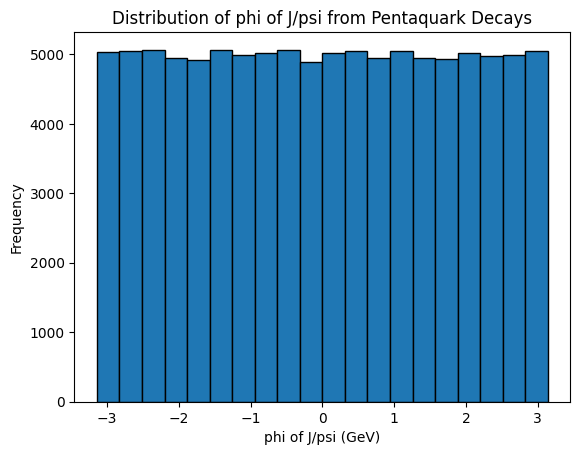

In [34]:
# Plot the distribution of J/psi p_T
plt.hist(jpsi_phi_values, bins=20, edgecolor='k')
plt.xlabel(r"phi of J/psi (GeV)")
plt.ylabel("Frequency")
plt.title(r"Distribution of phi of J/psi from Pentaquark Decays")
plt.show()


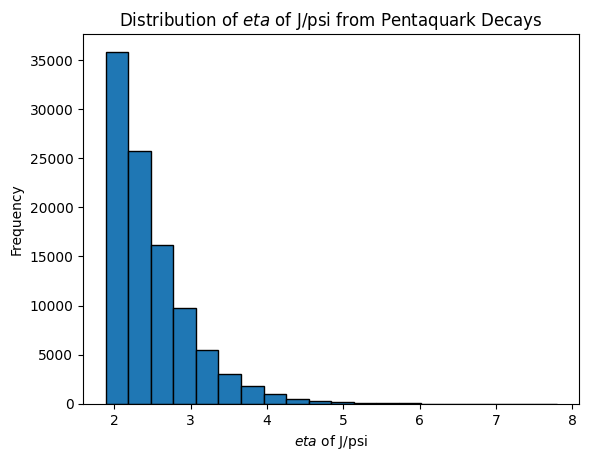

In [35]:
# Plot the distribution of J/psi p_T
plt.hist(jpsi_eta_values, bins=20, edgecolor='k')
plt.xlabel(r"$eta$ of J/psi")
plt.ylabel("Frequency")
plt.title(r"Distribution of $eta$ of J/psi from Pentaquark Decays")
plt.show()


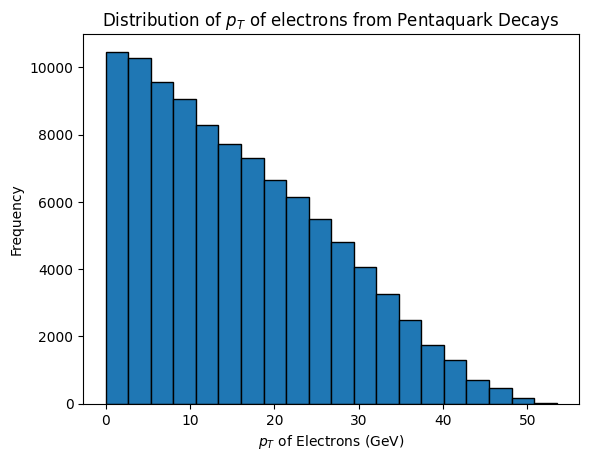

In [36]:
plt.hist(ele_pt_values, bins=20, edgecolor='k')
plt.xlabel(r"$p_T$ of Electrons (GeV)")
plt.ylabel("Frequency")
plt.title(r"Distribution of $p_T$ of electrons from Pentaquark Decays")
plt.show()

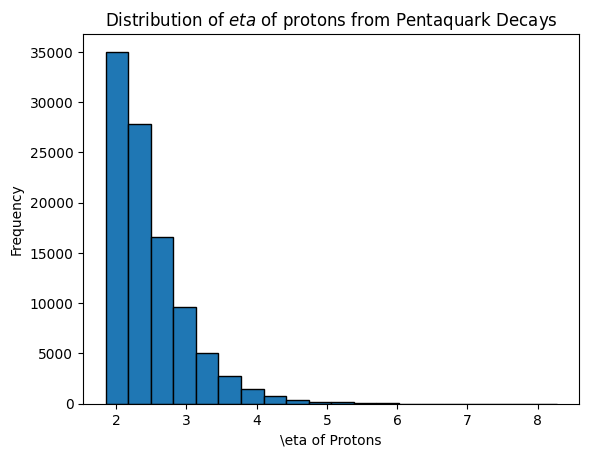

In [37]:
plt.hist(proton_eta_values, bins=20, edgecolor='k')
plt.xlabel(r"\eta of Protons")
plt.ylabel("Frequency")
plt.title(r"Distribution of $eta$ of protons from Pentaquark Decays")
plt.show()

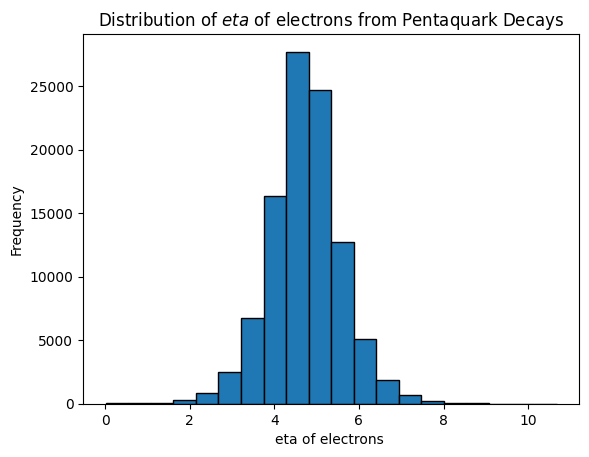

In [19]:
plt.hist(ele_eta_values, bins=20, edgecolor='k')
plt.xlabel(r"eta of electrons ")
plt.ylabel("Frequency")
plt.title(r"Distribution of $eta$ of electrons from Pentaquark Decays")
plt.show()

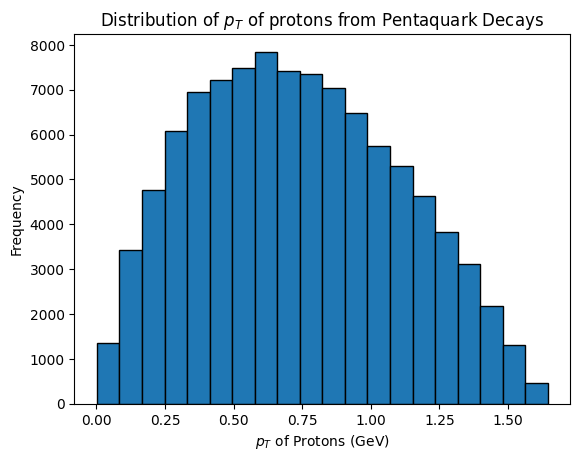

In [20]:
plt.hist(proton_pt_values, bins=20, edgecolor='k')
plt.xlabel(r"$p_T$ of Protons (GeV)")
plt.ylabel("Frequency")
plt.title(r"Distribution of $p_T$ of protons from Pentaquark Decays")
plt.show()

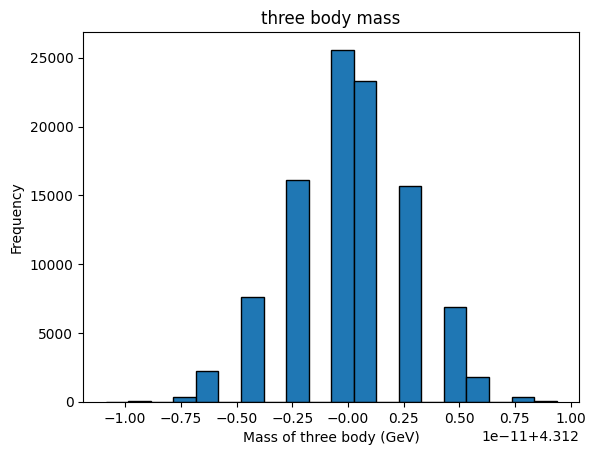

In [21]:
plt.hist(reco_mass_values, bins=20, edgecolor='k')
plt.xlabel(r"Mass of three body (GeV)")
plt.ylabel("Frequency")
plt.title(r"three body mass")
plt.show()

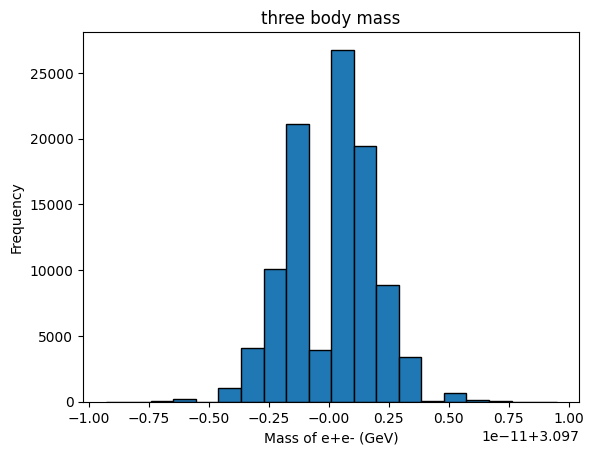

In [22]:
plt.hist(reco_jpsimass_values, bins=20, edgecolor='k')
plt.xlabel(r"Mass of e+e- (GeV)")
plt.ylabel("Frequency")
plt.title(r"three body mass")
plt.show()

In [23]:
jpsi_lab.m

np.float64(3.0970000000000915)